In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import truncnorm
import pickle
import flexcode
from flexcode.regression_models import NN, RandomForest 

import matplotlib.pyplot as plt

import local_conformal as lc

# Data Visualization and Exploration

In [2]:
def generate_data_b0(size = 1000):
    """
    X : uniform(-4,4)
    X'|X = x:
        if (x >= 0):
            x - 2
        else:
            -1 * (x + 2)
    Y |X' = x':
    sd(x') =  1 + 1.5 * |x'|
    truncated_max(x') = .5 + log(2/|x'|)
    df(x') =  1/8*(2*(3 - |x'|))^3 + 2
    \bar{y} = x'
    if x' <= 0:
        y = \bar{y} + truncated_norm_rvs(sd = sd(x),
                                     lower = -1*truncated_max(x)*sd(x),
                                     max = truncated_max(x)*sd(x))
    else:
        y = \bar{y} + sd(x') * student_t(df(x'))
    """

    x = np.random.uniform(-4,4, size)
    x2 = x.copy()
    x2[x >= 0] = x[x >= 0] - 2
    x2[x < 0] = -1*(x[x < 0] + 2)

    sd_val = 1 + 1.5 * np.abs(x2)
    bb = 2/3*(.5 + np.log(2/np.abs(x2))) * sd_val
    aa = -1 * bb

    df = 1/8 * (2*(3- np.abs(x2)))**3 + 2
    y = x.copy()


    y[x2 <= 0] += truncnorm.rvs(a = aa[x2 <= 0],
                               b = bb[x2 <= 0],
                               loc = np.zeros(np.sum(x2 <= 0)),
                               scale = sd_val[x2 <= 0],
                               size = np.sum(x2 <= 0))
    y[x2 > 0] += sd_val[x2 > 0] * np.random.standard_t(df[x2 > 0],
                                                     size = np.sum(x2 > 0))


    return x,y


def _generate_data_b0_cond_inner(X, size = 300):
    """
    X'|X = x:
        if (x >= 0):
            x - 2
        else:
            -1 * (x + 2)
    Y |X' = x':
    sd(x') =  1 + 1.5 * |x'|
    truncated_max(x') = .5 + log(2/|x'|)
    df(x') =  1/8*(2*(3 - |x'|))^3 + 2
    \bar{y} = x'
    if x' <= 0:
        y = \bar{y} + truncated_norm_rvs(sd = sd(x),
                                     lower = -1*truncated_max(x)*sd(x),
                                     max = truncated_max(x)*sd(x))
    else:
        y = \bar{y} + sd(x') * student_t(df(x'))
    x is a singleton
    """
    X_all = np.repeat(X, size)
    x2 = X_all.copy()
    x2[x >= 0] = x[x >= 0] - 2
    x2[x < 0] = -1*(x[x < 0] + 2)

    sd_val = 1 + 1.5 * np.abs(x2)
    bb = 2/3*(.5 + np.log(2/np.abs(x2))) * sd_val
    aa = -1 * bb

    df = 1/8 * (2*(3- np.abs(x2)))**3 + 2
    y = x.copy()


    y[x2 <= 0] += truncnorm.rvs(a = aa[x2 <= 0],
                               b = bb[x2 <= 0],
                               loc = np.zeros(np.sum(x2 <= 0)),
                               scale = sd_val[x2 <= 0],
                               size = np.sum(x2 <= 0))
    y[x2 > 0] += sd_val[x2 > 0] * np.random.standard_t(df[x2 > 0],
                                                     size = np.sum(x2 > 0))



    return y

def generate_data_b0_cond(X, size = 300):
    """
    X'|X = x:
        if (x >= 0):
            x - 2
        else:
            -1 * (x + 2)
    Y |X' = x':
    sd(x') =  1 + 1.5 * |x'|
    truncated_max(x') = .5 + log(2/|x'|)
    df(x') =  1/8*(2*(3 - |x'|))^3 + 2
    \bar{y} = x'
    if x' <= 0:
        y = \bar{y} + truncated_norm_rvs(sd = sd(x),
                                     lower = -1*truncated_max(x)*sd(x),
                                     max = truncated_max(x)*sd(x))
    else:
        y = \bar{y} + sd(x') * student_t(df(x'))
    """

    out = [_generate_data_b0_cond_inner(x, size = size) for x in X]

    return (out)

In [3]:
x, y = generate_data_b0(10000)

In [4]:
df = pd.DataFrame(data = {"x":x, "y":y})

In [5]:
import plotnine as p9

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


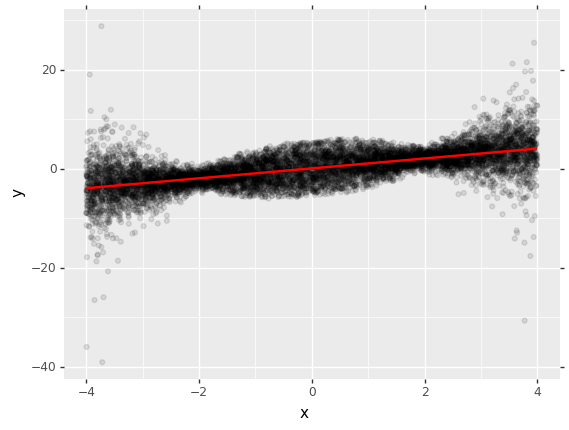

<ggplot: (-9223363256606938680)>

In [6]:
p9.ggplot(df) +\
    p9.geom_point(p9.aes(x="x",y="y"),
                 alpha = .1) +\
    p9.geom_smooth(p9.aes(x="x",y="y"), color = "red")

In [7]:
from sklearn.linear_model import LinearRegression
X = x.reshape((-1,1))
reg = LinearRegression().fit(X,y)

In [8]:
reg.intercept_, reg.coef_

(0.040249629442472415, array([1.00042606]))

In [9]:
yhat = reg.predict(X)

In [10]:
res2 = (y-yhat)**2

In [11]:
from csaps import csaps

In [12]:
order = x.argsort()
x_order = x[order]
res2_order = res2[order]

In [13]:
xx = np.linspace(-4,4, 80001)
res2_predict = csaps(x_order, res2_order, xx, smooth=0.8)

In [14]:
df_res2 = pd.DataFrame(data = {"x":x , "res2":res2})
df_smooth = pd.DataFrame(data = {"x":xx, "res2": res2_predict})

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


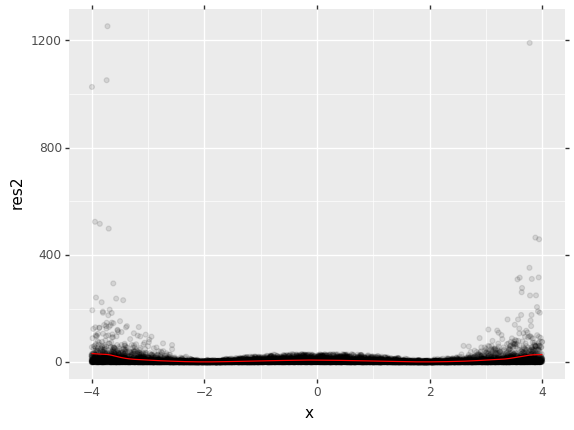

<ggplot: (-9223363256610968274)>

In [15]:
p9.ggplot(df_res2) +\
    p9.geom_point(p9.aes(x="x", y = "res2"), alpha = .1) +\
    p9.geom_line(data = df_smooth, mapping = p9.aes(x="x", y = "res2"), 
                 color = "red")

[-4,-2]

For [-4,-2] and [2,4]: max is like 30 for res2, [-2,2] has max like 7.5. scale so both the same?

aka for values [-4,-2] and [2,4] scale the $\sigma^2$ by 1/4.

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


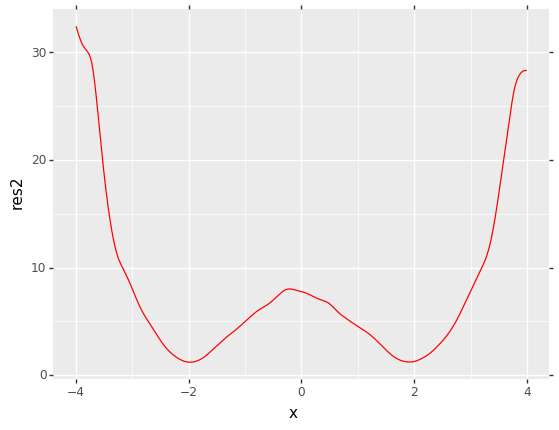

<ggplot: (-9223363256610971690)>

In [16]:
p9.ggplot(df_res2) +\
    p9.geom_line(data = df_smooth, mapping = p9.aes(x="x", y = "res2"), 
                 color = "red")

## modified data

In [17]:
def generate_data_b0_attempt2(size = 1000):
    """
    X : uniform(-4,4)
    X'|X = x:
        if (x >= 0):
            x - 2
        else:
            -1 * (x + 2)
    Y |X' = x':
    sd(x') =  1 + 1.5 * |x'|
    truncated_max(x') = .5 + log(2/|x'|)
    df(x') =  1/8*(2*(3 - |x'|))^3 + 2
    \bar{y} = x'
    
    
    if x' <= 0:
        y = \bar{y} + truncated_norm_rvs(sd = sd(x),
                                     lower = -1*truncated_max(x)*sd(x),
                                     max = truncated_max(x)*sd(x))
    else:
        y = \bar{y} + [sd(x')*1/2] * student_t(df(x'))
    """

    x = np.random.uniform(-4,4, size)
    x2 = x.copy()
    x2[x >= 0] = x[x >= 0] - 2
    x2[x < 0] = -1*(x[x < 0] + 2)

    sd_val = 1 + 1.5 * np.abs(x2)
    bb = 2/3*(.5 + np.log(2/np.abs(x2))) * sd_val
    aa = -1 * bb

    df = 1/8 * (2*(3- np.abs(x2)))**3 + 2
    y = x.copy()


    y[x2 <= 0] += truncnorm.rvs(a = aa[x2 <= 0],
                               b = bb[x2 <= 0],
                               loc = np.zeros(np.sum(x2 <= 0)),
                               scale = sd_val[x2 <= 0],
                               size = np.sum(x2 <= 0))
    y[x2 > 0] += sd_val[x2 > 0] * 1/2 * np.random.standard_t(df[x2 > 0],
                                                     size = np.sum(x2 > 0))


    return x,y


In [18]:
import scipy.stats

In [19]:
def generate_data_b0_attempt2_pdf(x,y):
    """
    X : uniform(-4,4)
    X'|X = x:
        if (x >= 0):
            x - 2
        else:
            -1 * (x + 2)
    Y |X' = x':
    sd(x') =  1 + 1.5 * |x'|
    truncated_max(x') = .5 + log(2/|x'|)
    df(x') =  1/8*(2*(3 - |x'|))^3 + 2
    \bar{y} = x'
    
    
    if x' <= 0:
        y = \bar{y} + truncated_norm_rvs(sd = sd(x),
                                     lower = -1*truncated_max(x)*sd(x),
                                     max = truncated_max(x)*sd(x))
    else:
        y = \bar{y} + [sd(x')*1/2] * student_t(df(x'))
    """
    # converting x to x2 (which is on a much smaller grid)
    x2 = x.copy()
    x2[x >= 0] = x[x >= 0] - 2
    x2[x < 0] = -1*(x[x < 0] + 2)
    
    sd_val = 1 + 1.5 * np.abs(x2)
    bb = 2/3*(.5 + np.log(2/np.abs(x2))) * sd_val
    aa = -1 * bb

    df = 1/8 * (2*(3- np.abs(x2)))**3 + 2
    cde_out = -1 * np.ones(x2.shape)


    cde_out[x2 <= 0] = truncnorm.pdf(x = (y-x)[x2 <= 0],
                               a = aa[x2 <= 0],
                               b = bb[x2 <= 0],
                               loc = np.zeros(np.sum(x2 <= 0)),
                               scale = sd_val[x2 <= 0])
    cde_out[x2 > 0] = 1/(sd_val[x2 > 0] * 1/2) * scipy.stats.t.pdf(x = (y-x)[x2 > 0]/(sd_val[x2 > 0] * 1/2),
                                                     df = df[x2 > 0])


    return cde_out


In [20]:
x, y = generate_data_b0_attempt2(10000)

In [21]:
true_cde = generate_data_b0_attempt2_pdf(np.array(x),np.array(y))

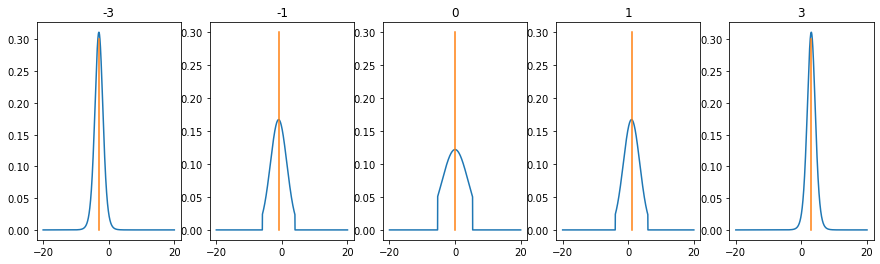

In [22]:
x_values = np.array([-3, -1,0,1,3])
yy_grid = np.linspace(-20,20, 10001)
fig, ax = plt.subplots(ncols = 5, figsize = (15,4))
for x_idx in range(5):
    cde_vec = generate_data_b0_attempt2_pdf(np.array([x_values[x_idx]]*yy_grid.shape[0]), yy_grid)
    ax[x_idx].plot(yy_grid,cde_vec)
    ax[x_idx].set_title(x_values[x_idx])
    ax[x_idx].plot([x_values[x_idx]]*2, [0,.3])

In [23]:
df = pd.DataFrame(data = {"x":x, "y":y, "cde":true_cde})

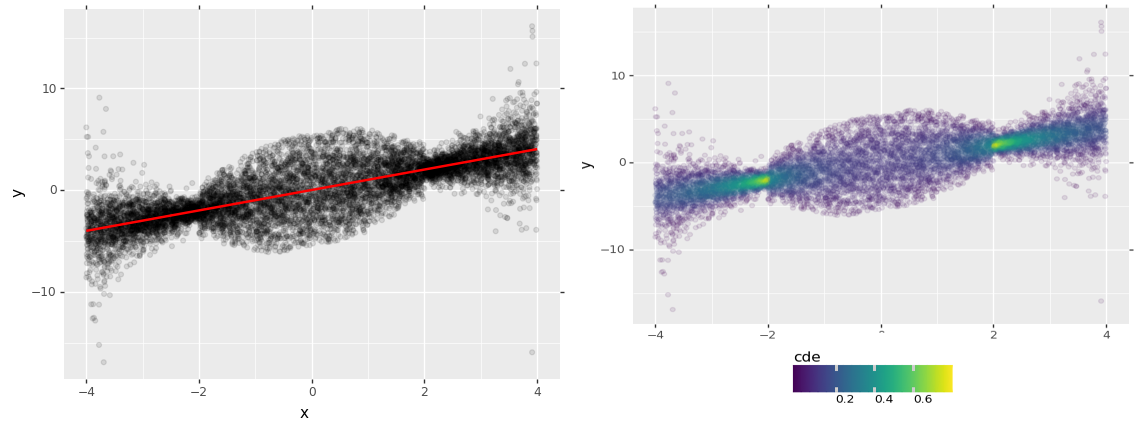

In [24]:
gg_raw_points = p9.ggplot(df) +\
    p9.geom_point(p9.aes(x="x",y="y"),
                 alpha = .1) +\
    p9.geom_smooth(p9.aes(x="x",y="y"), color = "red")

gg_points_plus_cde = p9.ggplot(df) +\
    p9.geom_point(p9.aes(x="x",y="y", color = "cde"),
                 alpha = .1) +\
    p9.theme(legend_position = "bottom")

lc.arrangegrob([gg_raw_points, gg_points_plus_cde], nrow = 1)

In [25]:
from sklearn.linear_model import LinearRegression
X = x.reshape((-1,1))
reg = LinearRegression().fit(X,y)

In [26]:
yhat = reg.predict(X)
res2 = (y-yhat)**2

In [27]:
order = x.argsort()
x_order = x[order]
res2_order = res2[order]

In [28]:
xx = np.linspace(-4,4, 80001)
res2_predict = csaps(x_order, res2_order, xx, smooth=0.8)

In [29]:
df_res2 = pd.DataFrame(data = {"x":x , "res2":res2})
df_smooth = pd.DataFrame(data = {"x":xx, "res2": res2_predict})

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


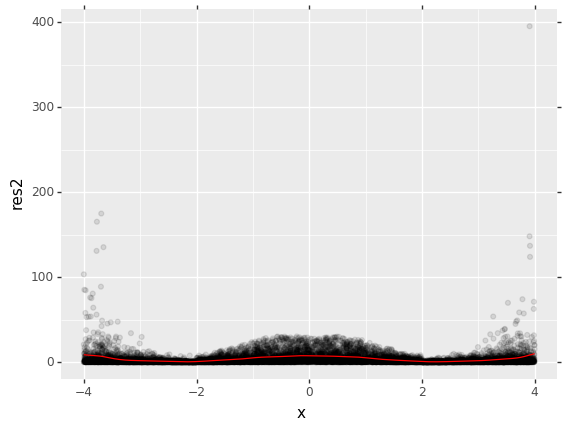

<ggplot: (8780218023723)>

In [30]:
p9.ggplot(df_res2) +\
    p9.geom_point(p9.aes(x="x", y = "res2"), alpha = .1) +\
    p9.geom_line(data = df_smooth, mapping = p9.aes(x="x", y = "res2"), 
                 color = "red")

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


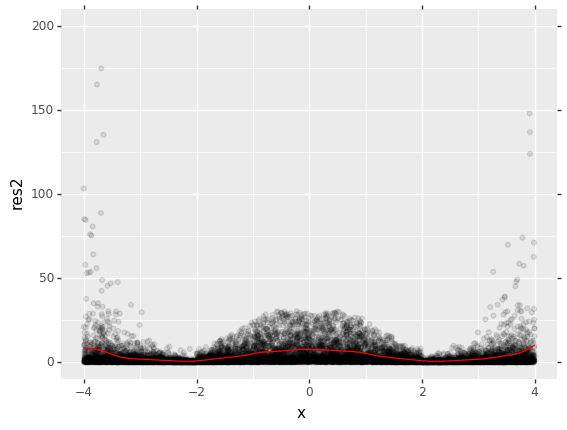

<ggplot: (8780219286792)>

In [31]:
p9.ggplot(df_res2) +\
    p9.geom_point(p9.aes(x="x", y = "res2"), alpha = .1) +\
    p9.geom_line(data = df_smooth, mapping = p9.aes(x="x", y = "res2"), 
                 color = "red") +\
    p9.ylim(0,200)

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


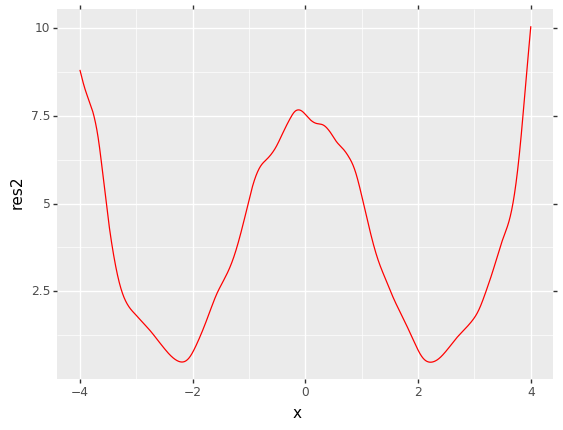

<ggplot: (-9223363256635488789)>

In [32]:
p9.ggplot(df_res2) +\
    p9.geom_line(data = df_smooth, mapping = p9.aes(x="x", y = "res2"), 
                 color = "red")

In [33]:
from sklearn.linear_model import LinearRegression
from csaps import csaps
X = x.reshape((-1,1))
reg = LinearRegression().fit(X,y)

# basic linear regression$^+$ model put into a class object

In [34]:
import scipy.stats

In [35]:
class simple_cde_reg: # need to define original fit, cde estimation, etc
    def __init__(self,x,y):
        """
        initialize CDE simple linear regression model
        
        Arguments:
        ----------
        x : numpy array (n,) x scalar values
        y : numpy array (n, ) y scalar values's CDE to be predicted from
            x.
        
        Returns:
        --------
        model object with fitted linear regression, and smooth sd estimator,
        and the ability to calculate CDE values on new y ranges
        """
        
        # linear regression -----
        X = x.reshape((-1,1))
        self.lin_reg = LinearRegression().fit(X,y)
        
        # smooth spline --------
        yhat = reg.predict(X)
        res2 = (y-yhat)**2
        
        order = x.argsort()
        x_order = x[order]
        res2_order = res2[order]
        
        self.smooth_split_info = (x_order, res2_order)
        
    def _cde_estimate_info(self,xx):
        """
        produce mean and sigma estimates for new xx values
        
        Arguments:
        ----------
        xx : numpy array (m,) x scalar values
        
        Returns:
        --------
        a tuple of mean values (numpy (m,)) and sd values (numpy (m,))
        """
        XX = xx.reshape((-1,1))
        yhat_predict = self.lin_reg.predict(XX)
        res2_predict = csaps(self.smooth_split_info[0], 
                             self.smooth_split_info[1], 
                             xx, smooth=0.8)
        
        return yhat_predict, np.sqrt(res2_predict)
    
    def cde_estimate(self,xx, yy):
        """
        CDE estimates for new observations
        
        Arguments:
        ----------
        xx : numpy array (m,) new x scalar values
        yy : numpy array (m,) new y scalar values's CDE to be predicted for 
            given x.
            
        Returns:
        --------
            vector (numpy array (m,)) of estimated conditional density values
            for yy|xx
        """
        
        yhat, sd = self._cde_estimate_info(xx)
        
        cde_vec_out = scipy.stats.norm.pdf(x = yy, loc = yhat, scale = sd)
        
        return cde_vec_out
    
    def cde_estimate_grid(self,xx, yy_grid):
        """
        A grid of CDE estimates for yy values in yy_grid for each new xx 
        value.
        
        Arguments:
        ----------
        xx : numpy array (m,) new x scalar values
        yy : numpy array (p,) grid of y values.
            
        Returns:
        --------
            numpy array (m,p) of estimated conditional density values
            for yy|xx. [i,j] = CDE(yy_grid[j]|xx[i])
        """
        
        yhat, sd = self._cde_estimate_info(xx)
        
        #ipdb.set_trace()
        cde_out = np.hstack([
            scipy.stats.norm.pdf(x = yy, loc = yhat, scale = sd).reshape((-1,1))
            for yy in yy_grid])
        
        return cde_out 
        

## visual tests of model

In [36]:
my_model = simple_cde_reg(x,y)

In [37]:
xx = np.linspace(-4,4, 80001)
y_hat, sd_hat = my_model._cde_estimate_info(xx)

In [38]:
df_vis = pd.DataFrame(data = {"x":xx,
                              "y_hat":y_hat,
                              "sd_hat":sd_hat,
                              "1se_min": y_hat-sd_hat,
                              "1se_max": y_hat+sd_hat})

In [39]:
import local_conformal as lc

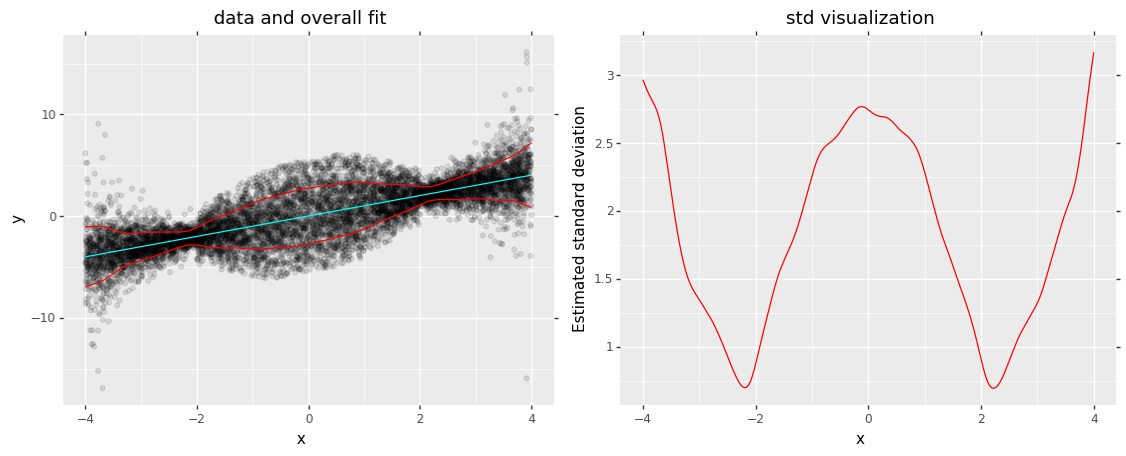

In [40]:
gg_overall_fit = p9.ggplot(df_vis) +\
    p9.geom_point(data = df, mapping = p9.aes(x = "x", y = "y"),
                 alpha = .1) +\
    p9.geom_line(p9.aes(x = "x", y = "y_hat"), color = "cyan") +\
    p9.geom_line(p9.aes(x = "x", y = "1se_min"), color = "red") +\
    p9.geom_line(p9.aes(x = "x", y = "1se_max"), color = "red") +\
    p9.labs(title = "data and overall fit")


gg_sd = p9.ggplot(df_vis) +\
    p9.geom_line(p9.aes(x = "x", y = "sd_hat"), color = "red") +\
    p9.labs(title = "std visualization",
            y = "Estimated standard deviation")


lc.arrangegrob([gg_overall_fit, gg_sd], nrow = 1)

In [41]:
cdes_test = my_model.cde_estimate(np.array(df.x), np.array(df.y))

In [42]:
df["cde"] = cdes_test

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


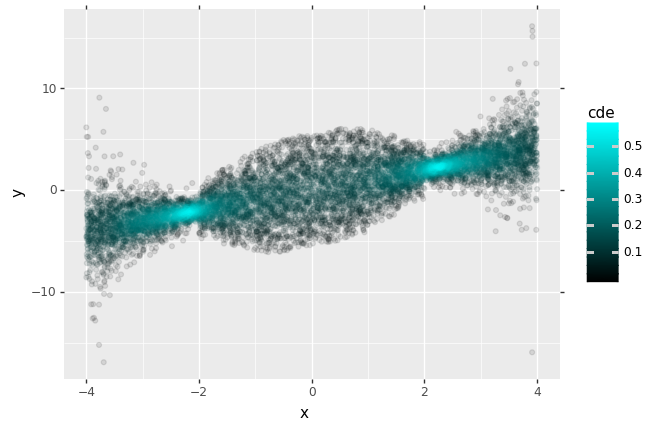

<ggplot: (-9223363256636140249)>

In [43]:
p9.ggplot() +\
    p9.geom_point(data = df, mapping = p9.aes(x = "x", y = "y", color = "cde"),
                     alpha = .1) +\
    p9.scale_color_gradient(low = "black", high = "cyan")

In [44]:
yy = np.linspace(-20,20, 10001)
xx = np.linspace(-4,4, 8001)

In [45]:
import ipdb

In [46]:
cdes_mat = my_model.cde_estimate_grid(xx, yy)

In [47]:
cdes_mat.shape, (xx.shape[0], yy.shape[0])

((8001, 10001), (8001, 10001))

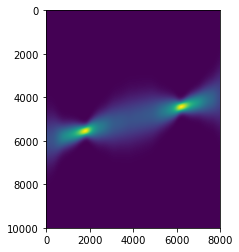

In [48]:
plt.imshow(cdes_mat.T[::-1])

# Conformal process

In [49]:
np.random.seed(707)
x_all,y_all = generate_data_b0_attempt2(10000)
data_all = pd.DataFrame(data = {"x":x_all, "y":y_all, "group_info":0}) # no stratified sampling needed

In [50]:
yy_splits = 10001
yy_grid = np.linspace(-20,20, yy_splits)
y_delta = yy_grid[1]- yy_grid[0]
y_range = np.array([yy.min(), yy.max()])
t_range_size = 500

In [51]:
k = 6
conformal_quantiles = np.arange(1,500)/500

## Izbicki

In [52]:
np.random.seed(2021)
data_izbicki_list = lc.stratified_data_splitting(data_all,
                                                prop_vec = np.array([1,1,0,1,1])/4)
x_train_iz,y_train_iz, _ = np.array(data_izbicki_list[0].x), \
                           np.array(data_izbicki_list[0].y), \
                           np.array(data_izbicki_list[0].group_info)
x_val_iz, y_val_iz, _ = np.array(data_izbicki_list[1].x), \
                       np.array(data_izbicki_list[1].y), \
                       np.array(data_izbicki_list[1].group_info)
x_cal_iz,y_cal_iz, _ = np.array(data_izbicki_list[3].x), \
                       np.array(data_izbicki_list[3].y), \
                       np.array(data_izbicki_list[3].group_info)
x_test_iz,y_test_iz, _ = np.array(data_izbicki_list[4].x), \
                         np.array(data_izbicki_list[4].y), \
                         np.array(data_izbicki_list[4].group_info)


In [53]:
g_train_iz = pd.cut(x_train_iz, bins = np.linspace(-4,4,100))
g_val_iz = pd.cut(x_val_iz, bins = np.linspace(-4,4,100))
g_cal_iz = pd.cut(x_cal_iz, bins = np.linspace(-4,4,100))
g_test_iz = pd.cut(x_test_iz, bins = np.linspace(-4,4,100))

### Fit model

In [54]:
izbicki_model = simple_cde_reg(x_train_iz,y_train_iz)

### True CDE 

In [55]:
true_cde_test_iz = np.vstack([generate_data_b0_attempt2_pdf(np.array([x]*yy_grid.shape[0]),
                               yy_grid) for x in x_test_iz])

### processing CDE

In [56]:
cde_train_iz = izbicki_model.cde_estimate_grid(x_train_iz, yy_grid)
cde_cal_iz = izbicki_model.cde_estimate_grid(x_cal_iz, yy_grid)
cde_test_iz = izbicki_model.cde_estimate_grid(x_test_iz, yy_grid)

t_grid = np.linspace(cde_train_iz.min(), cde_train_iz.max(), t_range_size)


profile_density_cal_iz = lc.profile_density(cde_cal_iz,
                                         t_grid = t_grid,
                                         z_delta = y_delta)

profile_density_test_iz = lc.profile_density(cde_test_iz,
                                         t_grid = t_grid,
                                         z_delta = y_delta)

### group by Izbicki (CDE)

In [57]:
kmeans_model_iz, grouping_cal_iz, _ = lc.profile_grouping(profile_density_cal_iz, 
                                            k = k)

_, _, grouping_test_iz = lc.profile_grouping(profile_test = profile_density_test_iz, Kmeans_model = kmeans_model_iz)

#### Visualizing groups!

In [58]:
vis_grouping_df_iz = pd.DataFrame(data = {"x": x_test_iz,
                                       "y": y_test_iz,
                                        "grouping": grouping_test_iz})
vis_grouping_df_iz["grouping"] = vis_grouping_df_iz["grouping"].astype(object)

/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/benjaminleroy/miniconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


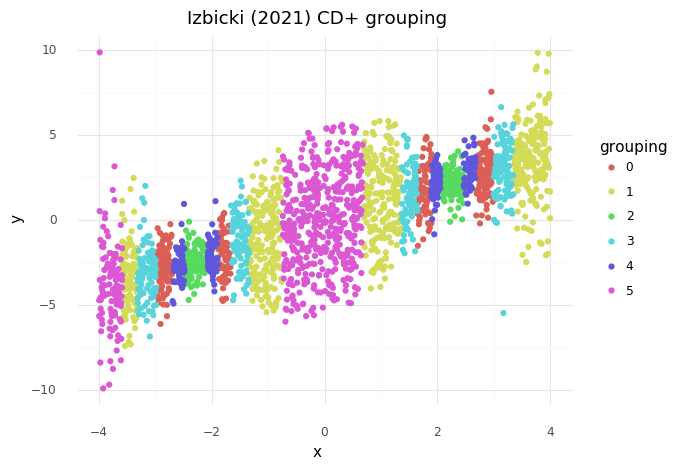

<ggplot: (-9223363256630701992)>

In [59]:
gg_vis_iz_groups = p9.ggplot(vis_grouping_df_iz) +\
    p9.geom_point(p9.aes(x = "x", y = "y", color = "grouping")) +\
    p9.labs(title = "Izbicki (2021) CD+ grouping") +\
    p9.theme_minimal()
gg_vis_iz_groups

### Apply split conformal

In [60]:
# get distribution of conformal scores -------
cs_cal_iz = izbicki_model.cde_estimate(x_cal_iz, y_cal_iz)

df_cs_group_cal_iz = pd.DataFrame(data = {"x": x_cal_iz,
                                          "cs": cs_cal_iz,
                                          "grouping":grouping_cal_iz})


# will need to calculate cuts per each threshold per group

cs_test_iz = izbicki_model.cde_estimate(x_test_iz, y_test_iz)


df_cs_group_test_iz = pd.DataFrame(data = {"x": x_test_iz,
                                           "cs": cs_test_iz,
                                           "grouping":grouping_test_iz})

thresholds_mat_test_iz, _ = lc.thresholds_per_group(df_cs_group_cal_iz,
                                              desired_props = conformal_quantiles,
                                              append = df_cs_group_test_iz)



In [61]:
true_thresholds_test_iz = lc.true_thresholds_out(true_cde = true_cde_test_iz, 
                                                z_delta = y_delta,
                                                expected_prop = conformal_quantiles)

In [62]:
test_bin_raw_iz = lc.difference_actual_validity(df_cs_group_test_iz,
                                                thresholds_mat_test_iz)

In [63]:
if False:
    v_iz,v_raw_iz, e_iz = lc.difference_validity_and_efficiency(true_cde = true_cde_test_iz,
                                                     predict_grid = cde_test_iz,
                                                     true_grid = true_cde_test_iz,
                                                     thresholds_predict = thresholds_mat_test_iz,
                                                     thresholds_true = true_thresholds_test_iz,
                                                     df_cs_grouping = df_cs_group_test_iz,
                                                     true_grouping = g_test_iz,
                                                     expected_prop = conformal_quantiles, 
                                                     z_delta = y_delta,
                                                     verbose = True)

#### Debugging

In [120]:
yy_grid = np.linspace(-4,4, 801)
y_delta = yy_grid[1]- yy_grid[0]

In [121]:
# cde
cde_unif = scipy.stats.uniform.pdf(yy_grid, 
                                   loc = -np.sqrt(3), 
                                   scale = 2*np.sqrt(3))
cde_norm = scipy.stats.norm.pdf(yy_grid)
cde_tri = scipy.stats.triang.pdf(yy_grid, 
                                 c = 1/2, 
                                 loc = -np.sqrt(6),
                                 scale = 2*np.sqrt(6))
cde_t = scipy.stats.t.pdf(yy_grid, df = 2)
cde_exp = scipy.stats.expon.pdf(yy_grid)

In [122]:
# hpd
hpd_unif = np.zeros(yy_grid.shape[0])
hpd_unif[np.logical_and(yy_grid <= np.sqrt(3), yy_grid >= -np.sqrt(3))] = 1
hpd_norm = lc.hpd_grid(cde_norm.reshape((1,-1)), y_delta).ravel()
hpd_tri =  lc.hpd_grid(cde_tri.reshape((1,-1)), y_delta).ravel()
hpd_t = lc.hpd_grid(cde_t.reshape((1,-1)), y_delta).ravel()
hpd_exp = lc.hpd_grid(cde_exp.reshape((1,-1)), y_delta).ravel()

In [134]:
# samples
np.random.seed(1)
n = 100
s_unif = scipy.stats.uniform.rvs(size = n, 
                                   loc = -np.sqrt(3), 
                                   scale = 2*np.sqrt(3))
s_norm = scipy.stats.norm.rvs(size = n)
s_tri = scipy.stats.triang.rvs(size = n, 
                                 c = 1/2, 
                                 loc = -np.sqrt(6),
                                 scale = 2*np.sqrt(6))
s_t = scipy.stats.t.rvs(size = n, df = 2)
s_exp = scipy.stats.expon.rvs(size = n)

s_all = np.vstack([s_unif.reshape((-1,1)),
                  s_norm.reshape((-1,1)),
                  s_tri.reshape((-1,1)),
                  s_t.reshape((-1,1)),
                  s_exp.reshape((-1,1)),])

estimated_norm_cde = scipy.stats.norm.pdf(s_all.ravel())

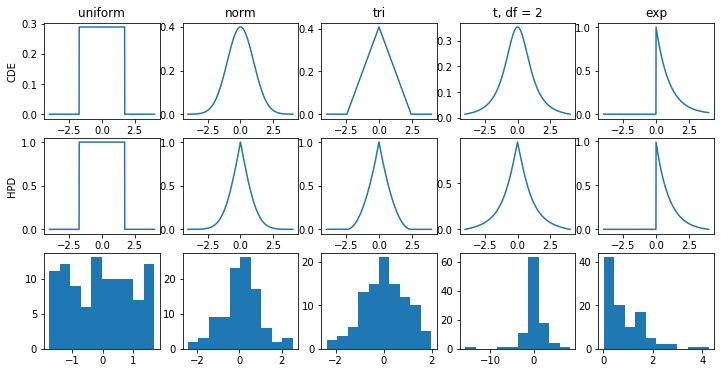

In [125]:
fig, ax = plt.subplots(nrows = 3, ncols = 5, figsize = (12,6))
ax[0,0].plot(yy_grid, cde_unif)
ax[0,0].set_title("uniform")
ax[0,0].set_ylabel("CDE")
ax[0,1].plot(yy_grid, cde_norm)
ax[0,1].set_title("norm")
ax[0,2].plot(yy_grid, cde_tri)
ax[0,2].set_title("tri")
ax[0,3].plot(yy_grid, cde_t)
ax[0,3].set_title("t, df = 2")
ax[0,4].plot(yy_grid, cde_exp)
ax[0,4].set_title("exp")
ax[1,0].plot(yy_grid, hpd_unif)
ax[1,0].set_ylabel("HPD")
ax[1,1].plot(yy_grid, hpd_norm)
ax[1,2].plot(yy_grid, hpd_tri)
ax[1,3].plot(yy_grid, hpd_t)
ax[1,4].plot(yy_grid, hpd_exp)
ax[2,0].hist(s_unif)
ax[2,1].hist(s_norm)
ax[2,2].hist(s_tri)
ax[2,3].hist(s_t)
ax[2,4].hist(s_exp);

In [138]:
# assume a guassian fit for all of them, 
true_cde = np.vstack([np.repeat(cde_unif.reshape((1,-1)), n, axis = 0),
                     np.repeat(cde_norm.reshape((1,-1)), n, axis = 0),
                     np.repeat(cde_tri.reshape((1,-1)), n, axis = 0),
                     np.repeat(cde_t.reshape((1,-1)), n, axis = 0),
                     np.repeat(cde_exp.reshape((1,-1)), n, axis = 0)
                     ])

predict_grid_cde = np.repeat(cde_norm.reshape((1,-1)), 5*n, axis = 0)
predict_grid_hpd = np.repeat(hpd_norm.reshape((1,-1)), 5*n, axis = 0)
true_grid_hpd = np.vstack([np.repeat(hpd_unif.reshape((1,-1)), n, axis = 0),
                     np.repeat(hpd_norm.reshape((1,-1)), n, axis = 0),
                     np.repeat(hpd_tri.reshape((1,-1)), n, axis = 0),
                     np.repeat(hpd_t.reshape((1,-1)), n, axis = 0),
                     np.repeat(hpd_exp.reshape((1,-1)), n, axis = 0)
                     ])


df_cs_grouping = pd.DataFrame(data = {"cs": estimated_norm_cde, 
                                     "grouping": np.ones(estimated_norm_cde.shape[0])})

true_grouping = np.array([0]*n+[1]*n+[2]*n+[3]*n+[4]*n)

## Us

In [ ]:
np.random.seed(4909)
data_us_list = lc.stratified_data_splitting(data_all, 
                                            prop_vec = np.array([.75,.75,.75,.75,1])/4)


x_train_us,y_train_us, _ = np.array(data_us_list[0].x), \
                           np.array(data_us_list[0].y), \
                           np.array(data_us_list[0].group_info)
x_val_us, y_val_us, _ = np.array(data_us_list[1].x), \
                       np.array(data_us_list[1].y), \
                       np.array(data_us_list[1].group_info)
x_cal_us,y_cal_us, _ = np.array(data_us_list[3].x), \
                       np.array(data_us_list[3].y), \
                       np.array(data_us_list[3].group_info)
x_test_us,y_test_us, _ = np.array(data_us_list[4].x), \
                         np.array(data_us_list[4].y), \
                         np.array(data_us_list[4].group_info)

In [ ]:
g_train_us = pd.cut(x_train_us, bins = np.linspace(-4,4,100))
g_val_us = pd.cut(x_val_us, bins = np.linspace(-4,4,100))
g_cal_us = pd.cut(x_cal_us, bins = np.linspace(-4,4,100))
g_test_us = pd.cut(x_test_us, bins = np.linspace(-4,4,100))

### True CDE + HPD

In [ ]:
true_cde_test_us = np.vstack([generate_data_b0_attempt2_pdf(np.array([x]*yy_grid.shape[0]),
                               yy_grid) for x in x_test_us])
true_hpd_test_us = lc.hpd_grid(true_cde_test_us, y_delta)

In [ ]:
# this is just the conformal scores since we're using HPD as the cs values
true_thresholds_test_us = np.repeat(conformal_quantiles.reshape((1,-1)),
                                    x_test_us.shape[0], axis = 0)

### Fit model (regression)

In [ ]:
us_model = simple_cde_reg(x_train_us,y_train_us)

### Prep for $\hat{r}$ quantile model

In [ ]:
import torch

In [ ]:
x_train_us_torch = torch.from_numpy(x_train_us.reshape((-1,1))).float()
x_val_us_torch = torch.from_numpy(x_val_us.reshape((-1,1))).float()
x_cal_us_torch = torch.from_numpy(x_cal_us.reshape((-1,1))).float()
x_test_us_torch = torch.from_numpy(x_test_us.reshape((-1,1))).float()

In [ ]:
cde_train_us = us_model.cde_estimate_grid(x_train_us, yy_grid)
cde_val_us = us_model.cde_estimate_grid(x_val_us, yy_grid)

hpd_train_base_us = lc.hpd_coverage(cde_train_us, yy_grid, y_train_us)
hpd_val_base_us = lc.hpd_coverage(cde_val_us, yy_grid, y_val_us)

In [ ]:
hpd_train_us = torch.from_numpy(hpd_train_base_us.reshape((-1,1)))
hpd_val_us = torch.from_numpy(hpd_val_base_us.reshape((-1,1)))

In [ ]:
lr_2, hidden1_2, hidden2_2 = 1e-03, 10, 10
epochs = 10000
quantiles = np.arange(1,500)/500

In [ ]:
q_model, q_opt, q_train_error_us, q_val_error_us = lc.tune_second_nn(x_train = x_train_us_torch,
                                                y_train = hpd_train_us,
                                                x_val = x_val_us_torch,
                                                y_val = hpd_val_us,
                                                epochs = epochs,
                                                quantiles = quantiles,
                                                n_hidden1 = hidden1_2,
                                                n_hidden2 = hidden2_2,
                                                lr = lr_2,
                                                verbose = True)

In [ ]:
hpd_estimate_cal_us = q_model(x_cal_us_torch).detach().numpy()
hpd_estimate_test_us = q_model(x_test_us_torch).detach().numpy()

### group by our approach ($\hat{r}$)

In [ ]:
kmeans_model_us, grouping_cal_us, _ = \
    lc.profile_grouping(profile_train = hpd_estimate_cal_us, k = k)

In [ ]:
_, _, grouping_test_us = lc.profile_grouping(profile_test = hpd_estimate_test_us, 
                                             Kmeans_model = kmeans_model_us)

#### Visualizing groups!

In [ ]:
vis_grouping_df_us = pd.DataFrame(data = {"x": x_test_us,
                                       "y": y_test_us,
                                        "grouping": grouping_test_us})
vis_grouping_df_us["grouping"] = vis_grouping_df_us["grouping"].astype(object)

In [ ]:
gg_vis_us_groups = p9.ggplot(vis_grouping_df_us) +\
    p9.geom_point(p9.aes(x = "x", y = "y", color = "grouping")) +\
    p9.labs(title = "Our approach's grouping") +\
    p9.theme_minimal()
gg_vis_us_groups

### Apply split Conformal

In [ ]:
cde_cal_us = us_model.cde_estimate_grid(x_cal_us,yy_grid)
cde_test_us = us_model.cde_estimate_grid(x_test_us,yy_grid)

In [ ]:
hpd_cal_base_us = lc.hpd_coverage(cde_cal_us, yy_grid, 
                                  y_cal_us)
hpd_test_base_us = lc.hpd_coverage(cde_test_us, yy_grid, 
                                   y_test_us)

In [ ]:
df_cs_group_cal_us = pd.DataFrame(data = {"x": x_cal_us,
                                        "cs": hpd_cal_base_us,
                                        "grouping":grouping_cal_us})



df_cs_group_test_us = pd.DataFrame(data = {"x": x_test_us,
                                           "cs": hpd_test_base_us,
                                           "grouping":grouping_test_us})

In [ ]:
thresholds_hpd_test_us, _ = lc.thresholds_per_group(df_cs_group_cal_us,
                                                  desired_props = conformal_quantiles,
                                                  append = df_cs_group_test_us)

In [ ]:
hpd_predict_grid_test_us = lc.hpd_grid(cde_test_us, 
                               z_delta = y_delta)

In [ ]:
if False:
    v_us, v_raw_us, e_us = lc.difference_validity_and_efficiency(
                                     true_cde = true_cde_test_us,
                                     predict_grid = hpd_predict_grid_test_us,
                                     true_grid = true_hpd_test_us,
                                     thresholds_predict = thresholds_hpd_test_us,
                                     thresholds_true = true_thresholds_test_us,
                                     df_cs_grouping = df_cs_group_test_us,
                                     true_grouping = g_test_us,
                                     expected_prop = conformal_quantiles, 
                                     z_delta = y_delta_us,
                                     verbose = False)

## Group Visual

In [ ]:
combined = lc.arrangegrob([gg_vis_iz_groups, gg_vis_us_groups], nrow = 2)
combined 

In [ ]:
save = False
if save:
    combined.save("images/iz_vs_us_linear_1d_groups.png")